<a href="https://colab.research.google.com/github/AtiyehNikbakht/DataFrameSparkPractice/blob/main/MyPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

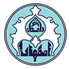







به نام خداوند بخشنده و مهربان 

# **درس: تحلیل سیسیتم داده‌های حجیم**
---

## استاد: دکتر محمدعلی نعمت‌بخش
دستیاران: فاطمه ابراهیمی، امیر سرتیپی، پریسا لطیفی





In [2]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 54.7 MB/s 


In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
#reading dataset from my googledrive
#!pip install gdown
#!pip install --upgrade --no-cache-dir gdown
#!gdown --id 1QBWK3tCvYGYkjbm5IUSdyM6XI8Ze5cmj

In [4]:
#reading dataset from my googledrive
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/MyHW2_dataset.zip

Mounted at /content/gdrive
Archive:  gdrive/My Drive/MyHW2_dataset.zip
   creating: products_parquet/
  inflating: products_parquet/.part-00000-0f978a44-491b-411b-9bf5-266bd9d4e836-c000.snappy.parquet.crc  
  inflating: products_parquet/.part-00001-0f978a44-491b-411b-9bf5-266bd9d4e836-c000.snappy.parquet.crc  
  inflating: products_parquet/.part-00002-0f978a44-491b-411b-9bf5-266bd9d4e836-c000.snappy.parquet.crc  
  inflating: products_parquet/.part-00003-0f978a44-491b-411b-9bf5-266bd9d4e836-c000.snappy.parquet.crc  
  inflating: products_parquet/.part-00004-0f978a44-491b-411b-9bf5-266bd9d4e836-c000.snappy.parquet.crc  
  inflating: products_parquet/.part-00005-0f978a44-491b-411b-9bf5-266bd9d4e836-c000.snappy.parquet.crc  
  inflating: products_parquet/.part-00006-0f978a44-491b-411b-9bf5-266bd9d4e836-c000.snappy.parquet.crc  
  inflating: products_parquet/.part-00007-0f978a44-491b-411b-9bf5-266bd9d4e836-c000.snappy.parquet.crc  
  inflating: products_parquet/.part-00008-0f978a44-491b-41

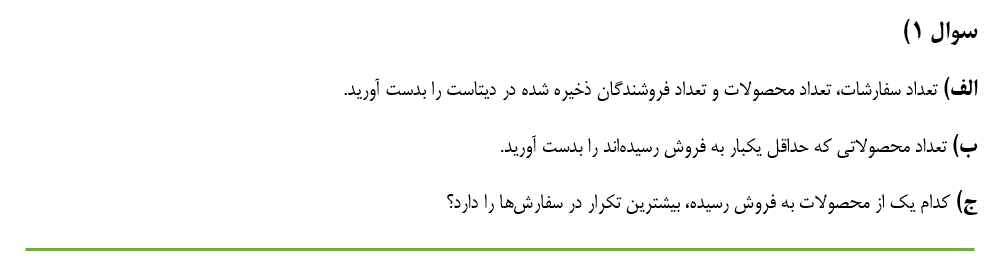

In [5]:
spark = SparkSession.builder.appName("Dataframe_practice").getOrCreate()

In [6]:
productDf = spark.read.parquet("/content/products_parquet")
saleDf = spark.read.parquet("/content/sales_parquet")
sellerDf = spark.read.parquet("/content/sellers_parquet")

# **(الف**

In [ ]:
print("Number of Products:", productDf.count())
print("Number of Sales:", saleDf.count())
print("Number of Sellers:", sellerDf.count())

Number of Products: 75000000
Number of Sales: 20000040
Number of Sellers: 10


# **(ب**

In [ ]:
saleDf.select('product_id').distinct().count()

993429

# **(ج**

In [ ]:
NumberOfsale = saleDf.groupBy('product_id').agg(F.count('order_id').alias('Number'))
NumberOfsale.filter(NumberOfsale.Number == NumberOfsale.agg(F.max('Number').alias('max_number')).collect()[0][0]).show()

+----------+--------+
|product_id|  Number|
+----------+--------+
|         0|19000000|
+----------+--------+



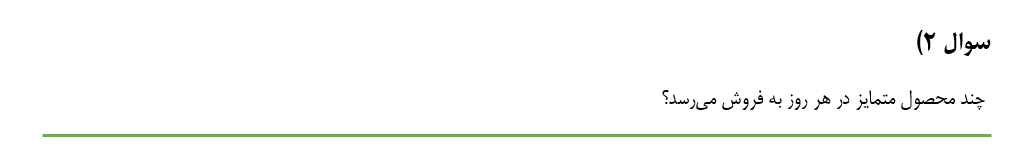

In [ ]:
saleDf.groupBy('date').agg(F.count_distinct('product_id')).collect()

[Row(date='2020-07-03', count(product_id)=100017),
 Row(date='2020-07-07', count(product_id)=99756),
 Row(date='2020-07-01', count(product_id)=100337),
 Row(date='2020-07-08', count(product_id)=99662),
 Row(date='2020-07-04', count(product_id)=99791),
 Row(date='2020-07-10', count(product_id)=98973),
 Row(date='2020-07-09', count(product_id)=100501),
 Row(date='2020-07-06', count(product_id)=100765),
 Row(date='2020-07-02', count(product_id)=99807),
 Row(date='2020-07-05', count(product_id)=99796)]

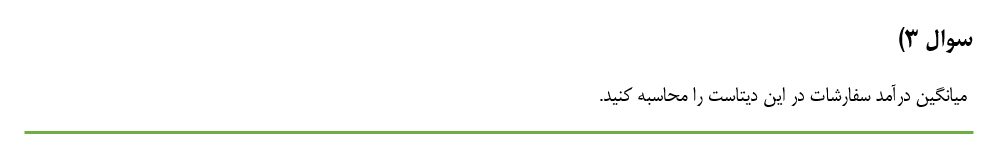

In [ ]:
saleDf = saleDf.withColumn('num_pieces_sold', saleDf['num_pieces_sold'].cast('Integer'))
productDf = productDf.withColumn('price', productDf['price'].cast('Integer'))

numProSaleDf = saleDf.groupBy('product_id').agg(F.sum('num_pieces_sold').alias('sum_pieces'))

income = numProSaleDf.join(productDf, 'product_id')
income = income.withColumn('Total', income.sum_pieces * income.price)
income.agg(F.avg('Total').alias('average_of_income')).show()

+-----------------+
|average_of_income|
+-----------------+
|25087.57743834738|
+-----------------+



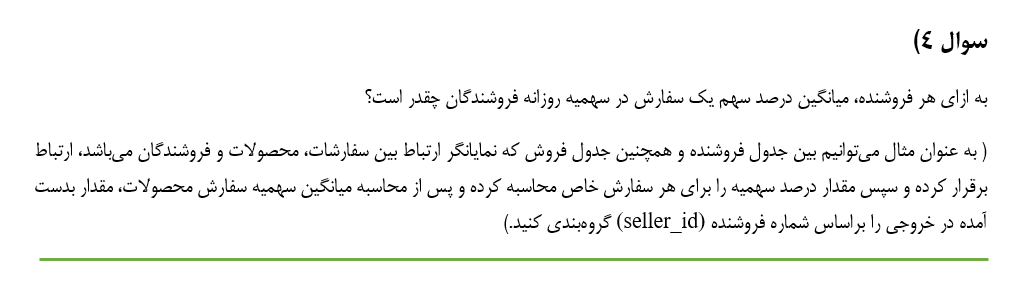

In [ ]:
sellerDf = sellerDf.withColumn('daily_target', sellerDf['daily_target'].cast('Integer'))

precentOfOrder = sellerDf.join(saleDf, 'seller_id', 'inner')
precentOfOrder = precentOfOrder.withColumn('precent_order', (precentOfOrder['num_pieces_sold']*100)/precentOfOrder['daily_target'])
precentOfOrder.groupBy('seller_id').agg({'precent_order': 'avg'}).show()

+---------+--------------------+
|seller_id|  avg(precent_order)|
+---------+--------------------+
|        0|0.002019885898947...|
|        7|0.002595228787788...|
|        3|0.016288853705659134|
|        8|0.009213030375408902|
|        5|0.004211073965904032|
|        6|0.004782147194369067|
|        9|0.003837913136180...|
|        1|  0.0196423336646103|
|        4|0.003296428039825...|
|        2|0.006690408001060533|
+---------+--------------------+



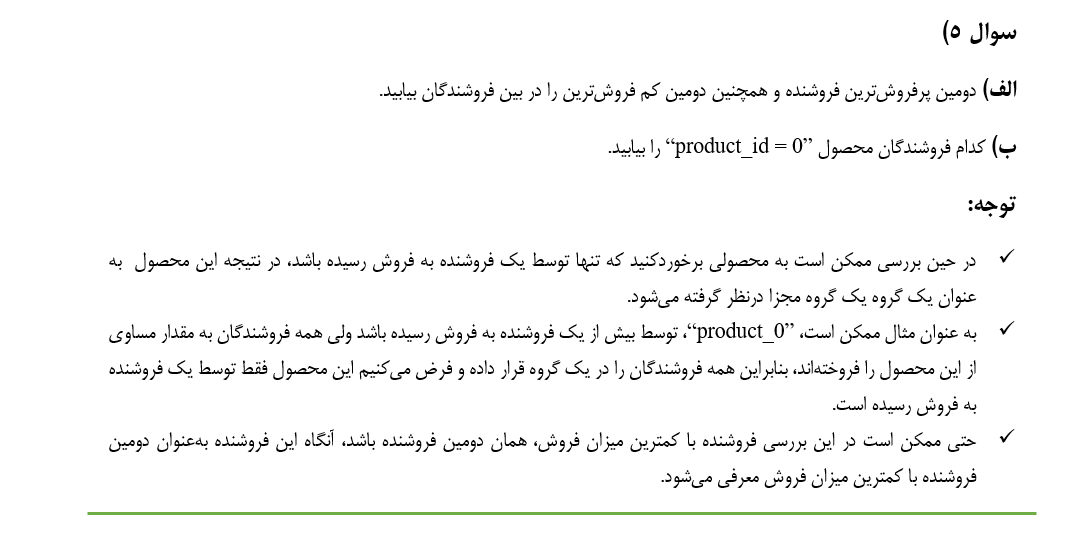

# **(الف**

In [ ]:
saleOfSeller = saleDf.groupBy('seller_id').agg(F.sum('num_pieces_sold').alias('num_sale_seller')).sort('num_sale_seller')
print('The second best seller:', saleOfSeller.collect()[-2])
print('The second lowest selling seller:', saleOfSeller.collect()[2])

The second best seller: Row(seller_id='9', num_sale_seller=5634837)
The second lowest selling seller: Row(seller_id='5', num_sale_seller=5601350)


# **(ب**

In [ ]:
sellerProZero = saleDf.filter('product_id == 0').select('seller_id').distinct()
sellerProZeroName = sellerProZero.join(sellerDf, 'seller_id')
sellerProZeroName.select('seller_name').show()

+-----------+
|seller_name|
+-----------+
|   seller_0|
+-----------+



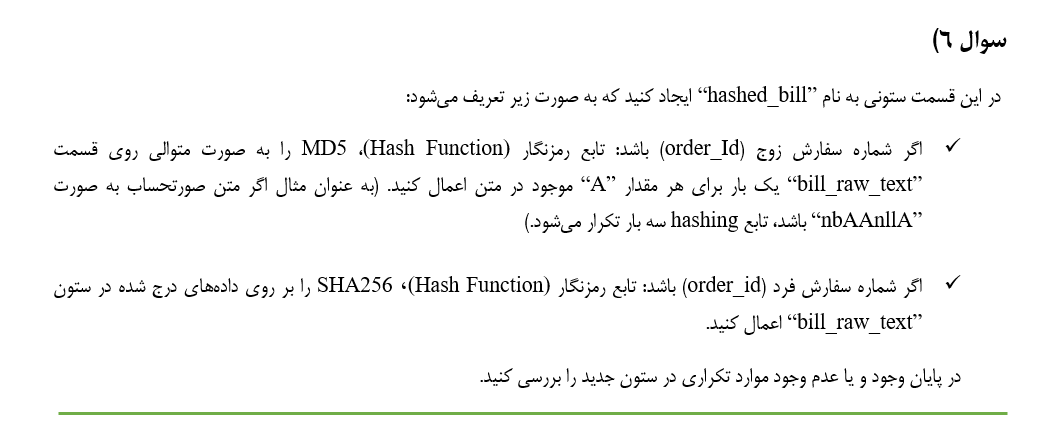

In [7]:
#It's better...
from pyspark.sql.types import StringType
import hashlib

@F.udf(returnType=StringType())
def f(billCol):
  hashBill = billCol
  a = billCol.count('A')
  for i in range(0, a):
    try:
      hashBill =  hashlib.md5(hashBill.encode()).hexdigest()
    except:
      break
  return hashBill

saleDf = saleDf.withColumn('order_id', saleDf['order_id'].cast('Integer'))
saleDf = saleDf.withColumn('hashed_bill', F.when(saleDf.order_id %2 == 0, f('bill_raw_text')).otherwise(F.sha2(saleDf.bill_raw_text, 256)))

print("Number of all hashed bill:", saleDf.select('hashed_bill').count())
print("Number of hashed bill without distinct:", saleDf.select('hashed_bill').distinct().count())


Number of all hashed bill: 20000040
Number of hashed bill without distinct: 20000040


In [ ]:
from pyspark.sql.types import StringType
import hashlib

@F.udf(returnType=StringType())
def f(billCol, countACol):
  hashBill = billCol
  a = countACol
  for i in range(0, int(a)):
    try:
      hashBill =  hashlib.md5(hashBill.encode()).hexdigest()
    except:
      break
  return hashBill

saleDf = saleDf.withColumn('order_id', saleDf['order_id'].cast('Integer'))

r = saleDf.filter(saleDf.order_id %2 == 0).select('order_id', 'bill_raw_text')
r = r.rdd.map(lambda x: (x[1].count('A'), x[0])).filter(lambda x: x[1] != '0')
r = r.toDF()

saleDf = saleDf.join(r , saleDf.order_id == r._2, 'leftouter')
saleDf = saleDf.na.fill({'_1': 0})
saleDf = saleDf.withColumn('hashed_bill', F.when(saleDf.order_id %2 == 0, f('bill_raw_text', '_1')).otherwise(F.sha2(saleDf.bill_raw_text, 256)))

print("Number of all hashed bill:", saleDf.select('hashed_bill').count())
print("Number of hashed bill without distinct:", saleDf.select('hashed_bill').distinct().count())


Number of all hashed bill: 20000040
Number of hashed bill without distinct: 20000040
